# Parallel Computing 1: iPyParallel
    Darren Lund
    Infinity War
    May 4th, 2018

## Problem 1
Initializes a `Client` object, create a `DirectView` with all available engines, and import `scipy.sparse` as `sparse` on all engines.

(This is just to make sure your cluster is running and connected correctly)

In [5]:
import numpy as np
from time import time
from numpy.random import normal
from matplotlib import pyplot as plt
from ipyparallel import Client

def initialize() :
    client = Client()

    dview = client[:]
    dview.execute('from scipy import sparse as sps')
    dview.block = True
    return client, dview

In [6]:
client, dview = initialize()

## Problem 2

Write a function `variables(dx)` that accepts a dictionary of variables.
Distribute the variables to all engines, then pull the variables back.

In [7]:
def variables(dx):
    dview.push(dx)
    good = True
    for key in dx.keys() :
        try :
            stored = dview.pull(key)
            correct = [dx[key] != stored[i] for i in range(len(stored))]
            if True in correct :
                bad_engine = correct.index(True)
                print("ERROR: variable '{}' was stored incorrectly on engine {}!".format(key,bad_engine))
                good = False
                break
        except KeyError :
            print("ERROR: varialbe {} was not stored!".format(key))
            good = False
            break
    if good :
        print("Everything was stored correctly.")

In [8]:
dx = {'a':2,'b':4,'c':27,'d':-5,'e':0}
variables(dx)

Everything was stored correctly.


## Problem 3

Write a function that accepts an integer n.
Instruct each engine to make n draws from the standard normal distribution, then hand back the minimum, maximum, and mean draw to the client.
Print the results.

In [7]:
def draw_statistics(n):
    dview.execute('from numpy.random import normal')
    dview.push({'n':n})
    dview.execute('data = [normal(0,1) for i in range(n)]')
    data = dview.pull('data')[0]
    result = dview.apply(lambda data : (min(data),max(data),1/len(data)*sum(data)), data)
    m = len(result)
    mins = [result[i][0] for i in range(m)]
    means = [result[i][2] for i in range(m)]
    maxs = [result[i][1] for i in range(m)]
    return means, maxs, mins

In [10]:
means, maxs, mins = draw_statistics(10000)
print('means : {}'.format(means))
print('maxs  : {}'.format(maxs))
print('mins  : {}'.format(mins))

means : [-0.004535585359960166, -0.004535585359960166, -0.004535585359960166, -0.004535585359960166]
maxs  : [4.073448616849613, 4.073448616849613, 4.073448616849613, 4.073448616849613]
mins  : [-3.9392203486990347, -3.9392203486990347, -3.9392203486990347, -3.9392203486990347]


## Problem 4

Use `draw_statistics()` to compare serial and parallel execution times.
For $n = 1000000, 5000000, 10000000, 15000000,$
1. Time how long it takes to run your function.
2. Time how long it takes to do the same process (make n draws and calculate and record the statistics) in a for loop with $N$ iterations, where $N$ is the number of engines running.

Plot the execution times against $n$.
You should notice an increase in efficiency in the parallel
version as the problem size increases.

In [ ]:
ns = [1000000, 5000000, 10000000, 15000000]
m = len(client.ids)

func_times = []
seri_times = []

for n in ns :
    start = time()
    means, maxs, mins = draw_statistics(n)
    mean = 1/len(means)*sum(means)
    max_ = max(maxs)
    min_ = min(mins)
    end = time()
    func_times.append(end-start)
    start = time()
    for k in range(m) :
        data = [normal(0,1) for i in range(n)]
        mean = 1/len(data)*sum(data)
        max_ = max(data)
        min_ = min(data)
    end = time()
    seri_times.append(end-start)

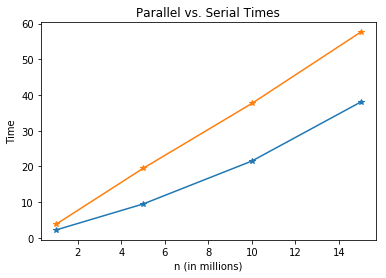

In [8]:
x_labels = [ns[i]/1000000 for i in range(len(ns))]
plt.plot(x_labels,func_times,'*-',label='Parallel')
plt.plot(x_labels,seri_times,'*-',label='Serial')
plt.xlabel('n (in millions)')
plt.ylabel('Time')
plt.title('Parallel vs. Serial Times')
plt.legend(loc='best')
plt.show()

## Problem 5

Write a function that accepts a function handle $f$ to integrate, bounds of integration, and the number of points to use for the approximation.
Parallelize the trapezoid rule in order to estimate the integral of $f$ over the given bounds.
That is, evenly divide the points among all available processors and run the trapezoid rule on each portion simultaneously.
The sum of the results of all the processors will be the estimation of the integral over the entire interval of integration.
Return this sum.

Demonstrate that your function works.

In [41]:
def trapezoid_parallel(f, a, b, N):
    points = np.linspace(a,b,N)
    h = points[1] - points[0]
    pairs = [(points[i],points[i+1]) for i in range(len(points)-1)]
    trap = lambda x : (h/2)*(f(x[0])+f(x[1]))
    return sum(dview.map(trap,pairs))

In [42]:
f = lambda x : x**2
a = 0
b = 4
N = 16
trapezoid_parallel(f,a,b,N+1)

21.375